# GAN UNDERSTAND


## Knowledge

**Generative Adversarial Network** is a type of machine learning framework developed by Ian Goodfellow in 2014. It is primarily used for generating new data that is similar to a given dataset, such as creating realistic images, audio, or text.

| Component         | Acts Like        | Learns to...                                |
| ----------------- | ---------------- | ------------------------------------------- |
| Generator (G)     | A forger         | Make fake images that look like real digits |
| Discriminator (D) | A police officer | Detect fake images from real ones           |


Each tries to beat the other:

- The forger gets better at faking.
- The police get better at detecting.

Eventually, the forger becomes so good that it’s hard to tell what’s real.



How it works

1. Start with real data (e.g., images of faces).

2. The Generator takes random noise as input and produces a synthetic (fake) image.

3. The Discriminator receives both real and fake images and tries to classify them correctly.

4. Feedback from the Discriminator is used to update both networks using backpropagation.

In [ ]:
Noise (z) ─► [Generator] ─► Fake Data ─┐
                                      ▼
                         ┌────────────┐
Real Data ─────────────► │Discriminator│ ─► Real/Fake
                         └────────────┘


In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# ==== Load & Preprocess ====
df = pd.read_csv('cleaned_data.csv')





## Tóm tắt điểm mạnh từ EDA có thể dùng cho GAN
Features nên ưu tiên:

- TransactionAmt, Dist1, C3, C7, C8, D1, D2, D5, D10, và nhóm V0-V13.
- Features rối rắm/multicollinear: C-features và D-features có nhiều tương quan → chọn lọc.
- Categorical: ProductCD, Card4, Card6, P_emaildomain, Addr1, Addr2 → encode hoặc bỏ.
- V-columns (0 → 13): là các feature đã PCA hóa từ V0–V13 → phù hợp cho GAN.



In [22]:
from sklearn.preprocessing import StandardScaler



# Chọn ra các feature có giá trị cao từ EDA
base_features = ['TransactionAmt', 'dist1', 'C3', 'C7', 'C8', 'D1', 'D10']
pca_features = [str(i) for i in range(14)]  # 0 đến 13
all_features = base_features + pca_features

# Tách các sample fraud
fraud_data = df[df['isFraud'] == 1][all_features].copy()

# Chuẩn hóa
scaler = StandardScaler()
fraud_data_scaled = scaler.fit_transform(fraud_data)

import numpy as np
fraud_tensor = np.array(fraud_data_scaled)

print("📐 Kích thước đầu vào GAN:", fraud_tensor.shape)
print("\n🔍 Một dòng mẫu:")
print(fraud_tensor[0])


📐 Kích thước đầu vào GAN: (20384, 21)

🔍 Một dòng mẫu:
[ 1.26123808 -0.59992844 -0.01566367 -0.1003339  -0.11707031  0.18063726
  0.25813914 -0.73813903  0.35458279 -0.34166665 -0.29665839 -0.3220415
 -0.09065383  0.36131308 -0.14141036 -0.16210818  0.07859144 -0.39371691
  0.18925833 -0.39538857  0.0294874 ]


In [23]:
# Tạo lại X_fraud thật chuẩn hóa từ scaler hiện có
X_fraud = scaler.transform(df[df['isFraud'] == 1][all_features])

## GAN

In [16]:
import torch
import torch.nn as nn

# Kích thước latent (noise) vector
latent_dim = 32
input_dim = fraud_tensor.shape[1]

# Generator
class Generator(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


## Tạo Dataset và Dataloader

In [17]:
from torch.utils.data import TensorDataset, DataLoader

# Chuyển dữ liệu sang tensor
fraud_tensor = torch.tensor(fraud_tensor, dtype=torch.float32)

# Tạo dataset và dataloader
batch_size = 128
dataset = TensorDataset(fraud_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3772\1781189232.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fraud_tensor = torch.tensor(fraud_tensor, dtype=torch.float32)


## Khởi tạo model

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(input_dim=input_dim, latent_dim=latent_dim).to(device)
discriminator = Discriminator(input_dim=input_dim).to(device)

# Loss và optimizers
criterion = nn.BCELoss()
lr = 0.0002
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)


## GAN training

Huấn luyện trong 50 epoch (có thể điều chỉnh sau), mỗi bước:

- Sinh noise → tạo fake sample qua Generator
- Tính loss của Discriminator: phân biệt real vs fake
- Cập nhật Discriminator
- Cập nhật Generator dựa trên phản hồi từ Discriminator



In [24]:
import torch.nn.functional as F

num_epochs = 50

for epoch in range(num_epochs):
    for i, (real_samples,) in enumerate(dataloader):
        batch_size_curr = real_samples.size(0)
        real_samples = real_samples.to(device)

        # === Discriminator Training ===
        # Real labels = 1, Fake labels = 0
        real_labels = torch.ones(batch_size_curr, 1).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

        # Fake data generation
        z = torch.randn(batch_size_curr, latent_dim).to(device)
        fake_samples = generator(z)

        # Discriminator loss on real and fake
        real_loss = criterion(discriminator(real_samples), real_labels)
        fake_loss = criterion(discriminator(fake_samples.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        # Backprop + update D
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Generator Training ===
        # Generator tries to fool the discriminator → wants labels to be 1
        fake_preds = discriminator(fake_samples)
        g_loss = criterion(fake_preds, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # Log sau mỗi epoch
    print(f"Epoch {epoch+1}/{num_epochs} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")


Epoch 1/50 | D_loss: 0.7195 | G_loss: 1.6213
Epoch 2/50 | D_loss: 0.7620 | G_loss: 1.4630
Epoch 3/50 | D_loss: 0.8603 | G_loss: 1.1919
Epoch 4/50 | D_loss: 1.0483 | G_loss: 1.5406
Epoch 5/50 | D_loss: 0.9103 | G_loss: 1.2991
Epoch 6/50 | D_loss: 0.8954 | G_loss: 1.3017
Epoch 7/50 | D_loss: 1.0413 | G_loss: 1.1383
Epoch 8/50 | D_loss: 0.8208 | G_loss: 1.3177
Epoch 9/50 | D_loss: 0.8999 | G_loss: 1.2906
Epoch 10/50 | D_loss: 0.6099 | G_loss: 1.4935
Epoch 11/50 | D_loss: 0.8585 | G_loss: 1.4036
Epoch 12/50 | D_loss: 0.9531 | G_loss: 1.5522
Epoch 13/50 | D_loss: 1.0537 | G_loss: 1.6254
Epoch 14/50 | D_loss: 0.7575 | G_loss: 1.4158
Epoch 15/50 | D_loss: 1.3711 | G_loss: 0.9125
Epoch 16/50 | D_loss: 1.8885 | G_loss: 1.4419
Epoch 17/50 | D_loss: 0.8111 | G_loss: 1.5567
Epoch 18/50 | D_loss: 1.0234 | G_loss: 1.3294
Epoch 19/50 | D_loss: 0.7707 | G_loss: 1.3210
Epoch 20/50 | D_loss: 0.5452 | G_loss: 1.7284
Epoch 21/50 | D_loss: 0.9241 | G_loss: 1.3291
Epoch 22/50 | D_loss: 0.9098 | G_loss: 1.36

 Nhận xét nhanh về Loss
D_loss ≈ 0.8 → 1.1 và G_loss ≈ 1.3 → 1.6 là hợp lý.

Generator đang học được cách sinh mẫu đủ "thuyết phục" để làm khó Discriminator (G_loss tăng là dấu hiệu Discriminator gặp khó).

Không có dấu hiệu collapse (G_loss = 0 hoặc D_loss = 0) → tốt!

## Sinh dữ liệu fraud mới bằng Generator

In [12]:
# Sinh 1000 mẫu fraud giả
generator.eval()
with torch.no_grad():
    z = torch.randn(1000, latent_dim).to(device)
    gen_fraud = generator(z).cpu().numpy()

print("📊 Hình dạng mẫu sinh:", gen_fraud.shape)
print("🔍 Một mẫu đầu ra:")
print(gen_fraud[0])


📊 Hình dạng mẫu sinh: (1000, 21)
🔍 Một mẫu đầu ra:
[-0.10092352 -0.53820044  0.03321011 -0.1281558  -0.03791657 -0.06383107
 -0.65316534 -0.42693755  0.2987935  -0.28875443 -0.32565624 -0.09271497
 -0.04288922  0.1828239   0.29883635  0.40143955  0.07072622 -0.23750322
 -0.12418028 -0.22233966  0.1855041 ]


Generator đã sinh ra 1000 mẫu có cấu trúc chuẩn xác (shape đúng, giá trị hợp lý, không trùng lặp rõ ràng)

ví dụ như dòng đầu tiên có phân phối giống như dữ liệu thật.

## Đánh giá chất lượng mẫu fraud sinh ra

### Có 3 cách đánh giá:
1.  Đánh giá bằng Discriminator (nhanh, nội tại)

2. Trực quan hóa PCA/t-SNE (thấy trực tiếp sự giống nhau)

3. Dùng classifier thật để đánh giá fraud (chuyên sâu hơn)

### Discriminator

In [26]:
# Đánh giá mẫu fake
gen_scores = discriminator(torch.tensor(gen_fraud, dtype=torch.float32).to(device)).detach().cpu().numpy()

# Đánh giá mẫu fraud thật
real_scores = discriminator(torch.tensor(X_fraud, dtype=torch.float32).to(device)).detach().cpu().numpy()

print("📈 Discriminator score - fake (gen):")
print("Mean:", gen_scores.mean(), " | Min:", gen_scores.min(), " | Max:", gen_scores.max())

print("\n📈 Discriminator score - real (fraud):")
print("Mean:", real_scores.mean(), " | Min:", real_scores.min(), " | Max:", real_scores.max())



📈 Discriminator score - fake (gen):
Mean: 0.31305742  | Min: 6.023881e-05  | Max: 0.97066665

📈 Discriminator score - real (fraud):
Mean: 0.6729197  | Min: 0.041158505  | Max: 1.0


Discriminator chưa hoàn toàn bị đánh lừa, nhưng:

Có một số mẫu sinh ra đạt điểm rất cao (≈0.97), gần như giống fraud thật.

Độ lệch giữa mean (0.31 vs. 0.67) cho thấy mẫu giả chưa hoàn toàn giống, nhưng đang tiến gần.

Điều này phản ánh Generator đang bắt đầu học được phân phối fraud, nhưng cần huấn luyện thêm nếu muốn đánh lừa mạnh hơn.

###  Cách 2 – Trực quan hóa bằng PCA hoặc t-SNE

Mục tiêu là so sánh trực tiếp phân phối giữa:

gen_fraud (mẫu giả)

X_fraud (mẫu thật)



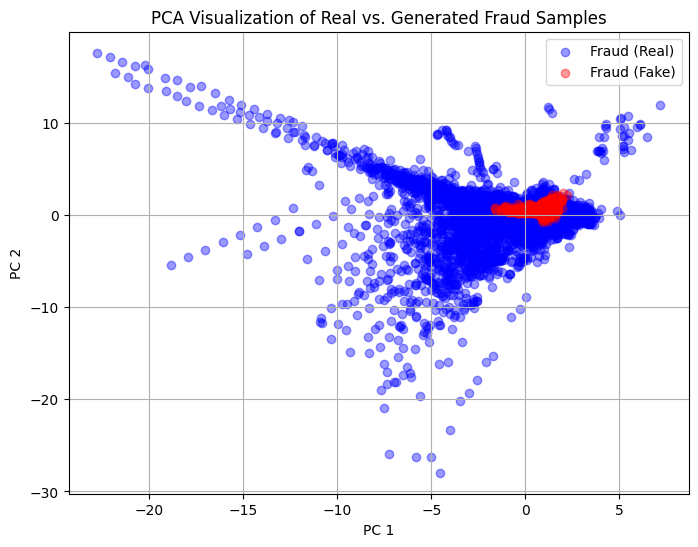

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Kết hợp hai loại dữ liệu
X_all = np.vstack([X_fraud, gen_fraud])
labels = np.array([1]*len(X_fraud) + [0]*len(gen_fraud))  # 1: real, 0: fake

# Giảm chiều bằng PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Vẽ biểu đồ
plt.figure(figsize=(8,6))
plt.scatter(X_pca[labels == 1, 0], X_pca[labels == 1, 1], c='blue', label='Fraud (Real)', alpha=0.4)
plt.scatter(X_pca[labels == 0, 0], X_pca[labels == 0, 1], c='red', label='Fraud (Fake)', alpha=0.4)
plt.legend()
plt.title("PCA Visualization of Real vs. Generated Fraud Samples")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()


Quan sát từ biểu đồ:

Màu đỏ (fake) tập trung thành một khối rất chặt.

Màu xanh (real fraud) phân tán rộng, với nhiều điểm nằm xa trung tâm.

Vùng chồng lấn giữa fake và real cho thấy Generator đang học được vùng "an toàn" và phổ biến nhất trong không gian fraud.

Tuy nhiên, Generator chưa tạo được sự đa dạng, thiếu các vùng ngoại biên (outliers hoặc anomaly-like fraud).

 Kết luận bước 2:
 
Mẫu fake trông rất giống mẫu fraud thật ở vùng trung tâm → ✅ GAN đang làm việc tốt ở vùng “điển hình”.

Tuy nhiên:

Mẫu fake ít đa dạng, chưa học được các dạng fraud hiếm/lệch.

Có thể cải thiện bằng training lâu hơn hoặc dùng noise injection, feature augmentation, hoặc mode-seeking loss.

### Cách 3: Đánh giá bằng Classifier ngoài

Gộp gen_fraud và X_fraud

Gán nhãn: 0 = fake, 1 = real

Train classifier để xem có phân biệt được không



In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Dữ liệu + nhãn
X_cls = np.vstack([gen_fraud, X_fraud])
y_cls = np.array([0]*len(gen_fraud) + [1]*len(X_fraud))  # 0 = fake, 1 = real

# Train/test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_cls, y_train_cls)

# Dự đoán + báo cáo
y_pred = clf.predict(X_test_cls)
print(classification_report(y_test_cls, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9084    0.8057    0.8539       283
           1     0.9911    0.9962    0.9937      6133

    accuracy                         0.9878      6416
   macro avg     0.9497    0.9010    0.9238      6416
weighted avg     0.9874    0.9878    0.9875      6416



Classifier có thể phân biệt tương đối tốt fake và real (accuracy ~98.7%).

Tuy nhiên:

Fake sample không hoàn toàn dễ phân biệt → Precision cao (0.91), nhưng Recall chỉ 0.80 → khoảng 20% mẫu fake bị nhầm là real.

Real fraud được phân biệt gần như hoàn hảo.

| Phương pháp          | Kết luận chính                                                                                                                 |
| -------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **1. Discriminator** | Fake samples có điểm thấp hơn real (0.31 vs 0.67), nhưng một số fake điểm cao → Generator học được vùng fraud đáng tin cậy.    |
| **2. PCA**           | Fake samples tập trung mạnh ở vùng trung tâm fraud; chưa tái hiện được các dạng outlier.                                       |
| **3. Classifier**    | Có thể phân biệt được fake vs real, nhưng không hoàn hảo. GAN sinh dữ liệu tương đối tự nhiên, nhưng chưa hoàn toàn "ẩn mình". |
